##**Connect Drive**


In [1]:
# from google.colab import drive
# drive.mount("/gdrive")
# current_dir = "/gdrive/MyDrive/pirate_dataset"
# %cd $current_dir

##**Load Dataset**

In [2]:
import pandas as pd

X_train = pd.read_csv('dataset/pirate_pain_train.csv')
y_train = pd.read_csv('dataset/pirate_pain_train_labels.csv')

X_test = pd.read_csv('dataset/pirate_pain_test.csv')


**Import Libraries**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cpu
Device: cpu


## Data Preprocessing

In [4]:
# Print the shape of the dataset
print(f"Dataset shape: {X_train.shape}")

# Display the first few rows of the dataset
X_train.head(10)

Dataset shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


In [5]:
# Display a summary of the dataset's structure and data types
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [6]:
# Merge features and labels
data = X_train.merge(y_train, on='sample_index')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
data['n_legs'] = data['n_legs'].map(map_dict)
data['n_hands'] = data['n_hands'].map(map_dict)
data['n_eyes'] = data['n_eyes'].map(map_dict)


In [ ]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# df has columns: ['sample_index', 'label']
N_VAL_USERS = 50
N_TEST_USERS = 50

# --- Step 1: Compute each user's dominant label (or label distribution)
user_labels = (
    data.groupby('sample_index')['label']
    .agg(lambda x: x.value_counts().index[0])  # dominant label per user
    .reset_index()
)

train_users, temp_users = train_test_split(
    user_labels['sample_index'],
    test_size=(N_VAL_USERS + N_TEST_USERS) / len(user_labels),
    stratify=user_labels['label'],
    random_state=SEED
)

# Split temp into val/test (also stratified)
temp_labels = user_labels[user_labels['sample_index'].isin(temp_users)]

val_users, test_users = train_test_split(
    temp_labels['sample_index'],
    test_size=N_TEST_USERS / (N_VAL_USERS + N_TEST_USERS),
    stratify=temp_labels['label'],
    random_state=SEED
)

# --- Step 3: Filter your main df
df_train = data[data['sample_index'].isin(train_users)]
df_val = data[data['sample_index'].isin(val_users)]
df_test = data[data['sample_index'].isin(test_users)]

# --- Step 4: Check label proportions
print("Label proportions:")
print("Train:\n", df_train['label'].value_counts(normalize=True))
print("Val:\n", df_val['label'].value_counts(normalize=True))
print("Test:\n", df_test['label'].value_counts(normalize=True))

Label proportions:
Train:
 label
no_pain      0.773619
low_pain     0.142602
high_pain    0.083779
Name: proportion, dtype: float64
Val:
 label
no_pain      0.78
low_pain     0.14
high_pain    0.08
Name: proportion, dtype: float64
Test:
 label
no_pain      0.76
low_pain     0.14
high_pain    0.10
Name: proportion, dtype: float64


In [38]:
df_train.shape, df_val.shape, df_test.shape

((89760, 40), (8000, 40), (8000, 40))

In [39]:
# Print the total number of pirates for each dataset
print(f"Total pirates in training set: {df_train['sample_index'].nunique()}")
print(f"Total pirates in validation set: {df_val['sample_index'].nunique()}")
print(f"Total pirates in test set: {df_test['sample_index'].nunique()}")

Total pirates in training set: 561
Total pirates in validation set: 50
Total pirates in test set: 50


In [8]:
data.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,2.0,2.0,2.0,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,2.0,2.0,2.0,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,2.0,2.0,2.0,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,2.0,2.0,2.0,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,2.0,2.0,2.0,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         104800 non-null  float64
 7   n_hands        104800 non-null  float64
 8   n_eyes         104800 non-null  float64
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

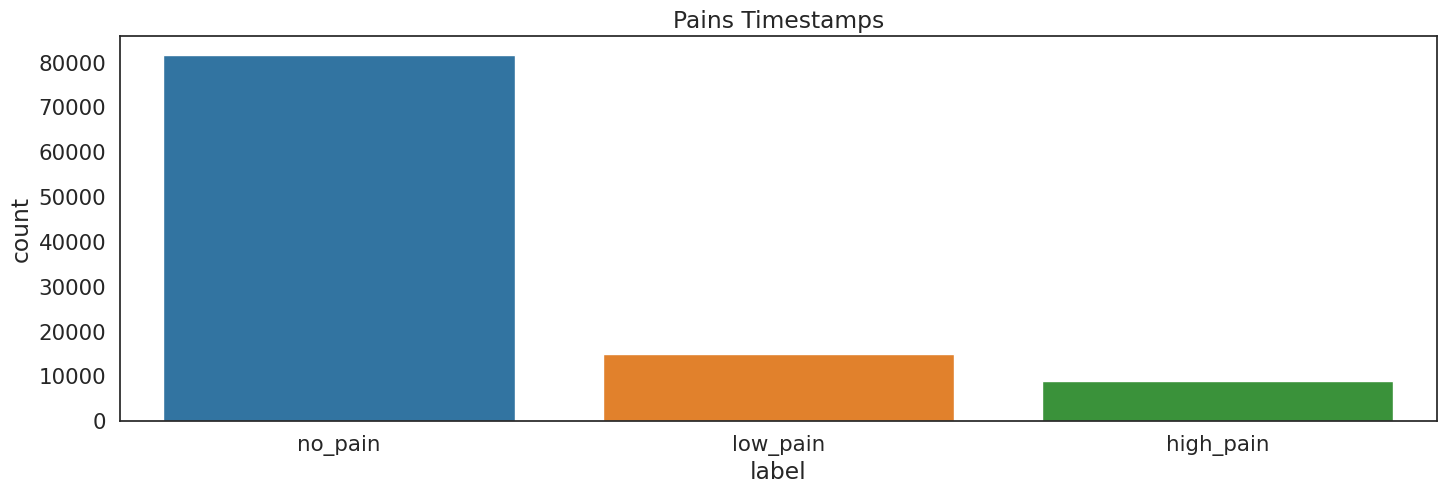

In [10]:
import seaborn as sns

# Visualise the count of timestamps for each pains
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=data,
    order=data['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pains Timestamps')

# Display the plot
plt.show()

In [11]:
# Define the columns to be normalised
scale_columns = [col for col in data.columns
                 if col.startswith('joint_') or col.startswith('pain_survey')]

# Calculate the minimum and maximum values from the training data only
mins_train = df_train[scale_columns].min()
maxs_train = df_train[scale_columns].max()

mins_val = df_val[scale_columns].min()
maxs_val = df_val[scale_columns].max()

mins_test = df_test[scale_columns].min()
maxs_test = df_test[scale_columns].max()


# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

    # Normalise the validation set
    df_val[column] = (df_val[column] - mins_val[column]) / (maxs_val[column] - mins_val[column])

    # Normalise the test set
    df_test[column] = (df_test[column] - mins_test[column]) / (maxs_test[column] - mins_test[column])


In [12]:
data.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,2.0,2.0,2.0,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,2.0,2.0,2.0,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,2.0,2.0,2.0,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,2.0,2.0,2.0,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,2.0,2.0,2.0,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


In [13]:
# Define a function to inspect sensor data for a specific label
def inspect_label(label, df):
    # Filter the DataFrame for the specified label and limit to 159 rows
    data = df[df['label'] == label][['joint_00', 'joint_01', 'joint_11', 'joint_15', 'joint_23', 'joint_28']][:159]

    # Plot the sensor data for each axis
    axis = data.plot(subplots=True, figsize=(17, 9), title=label)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')

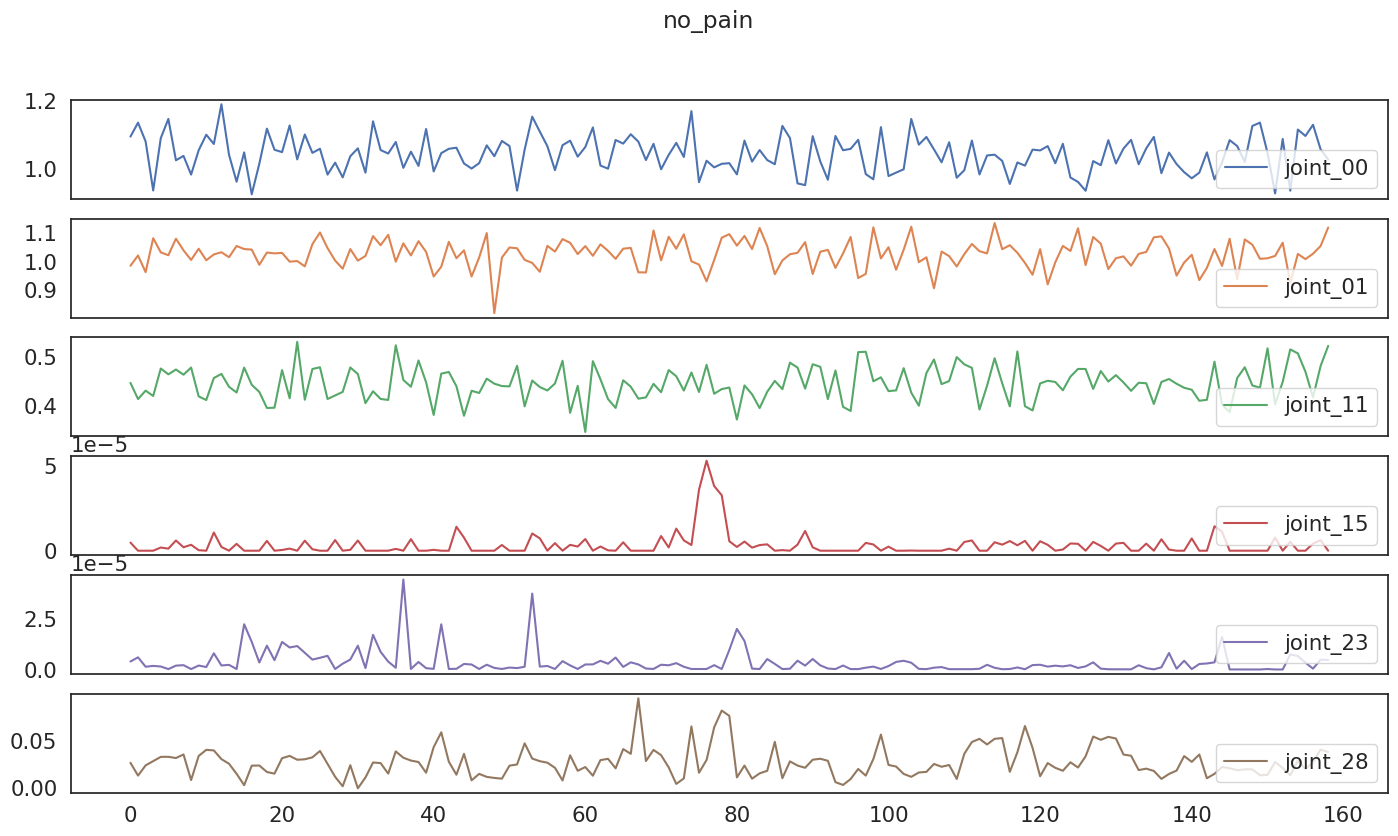

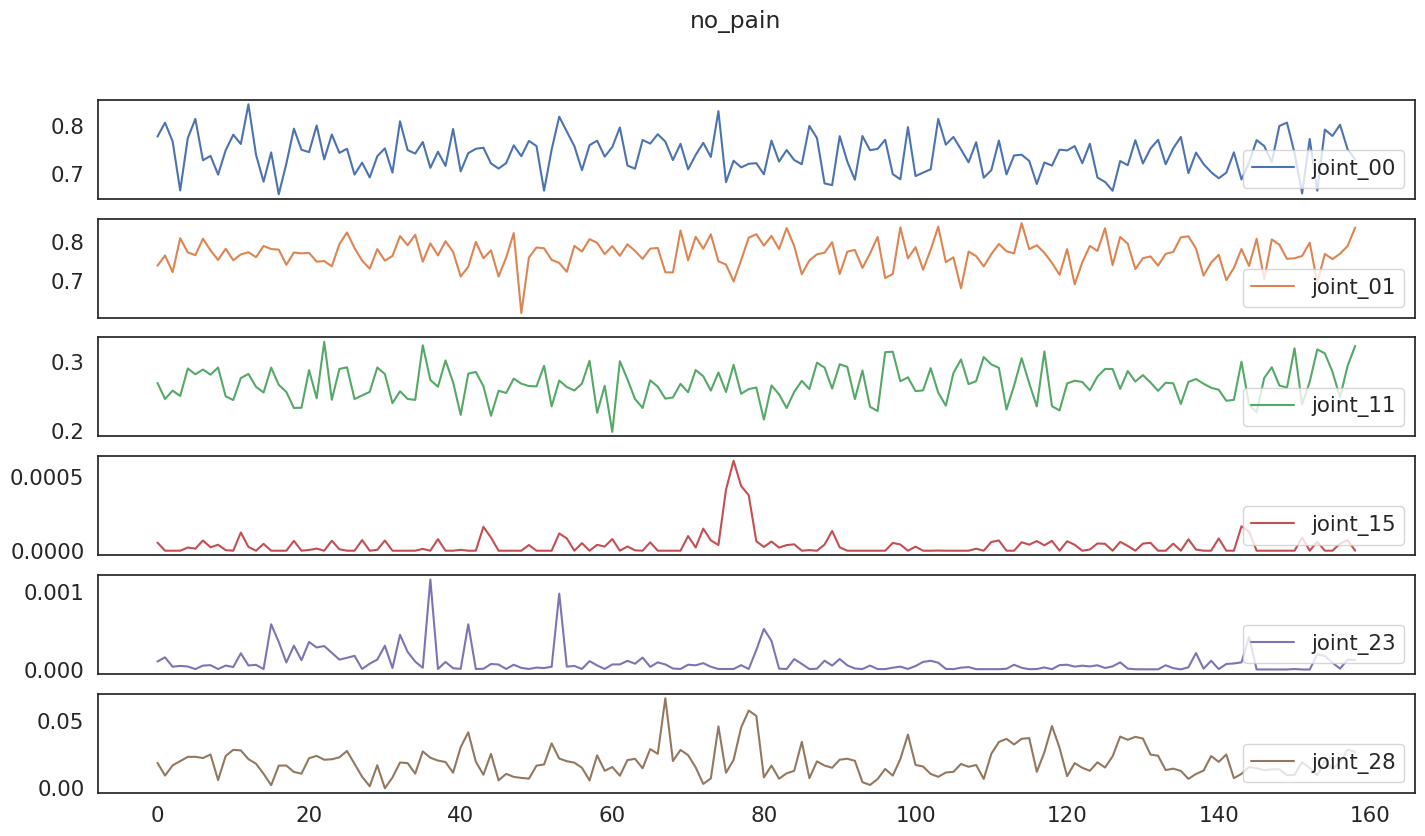

In [14]:
inspect_label('no_pain', data)

# Normalized training data
inspect_label('no_pain', df_train)

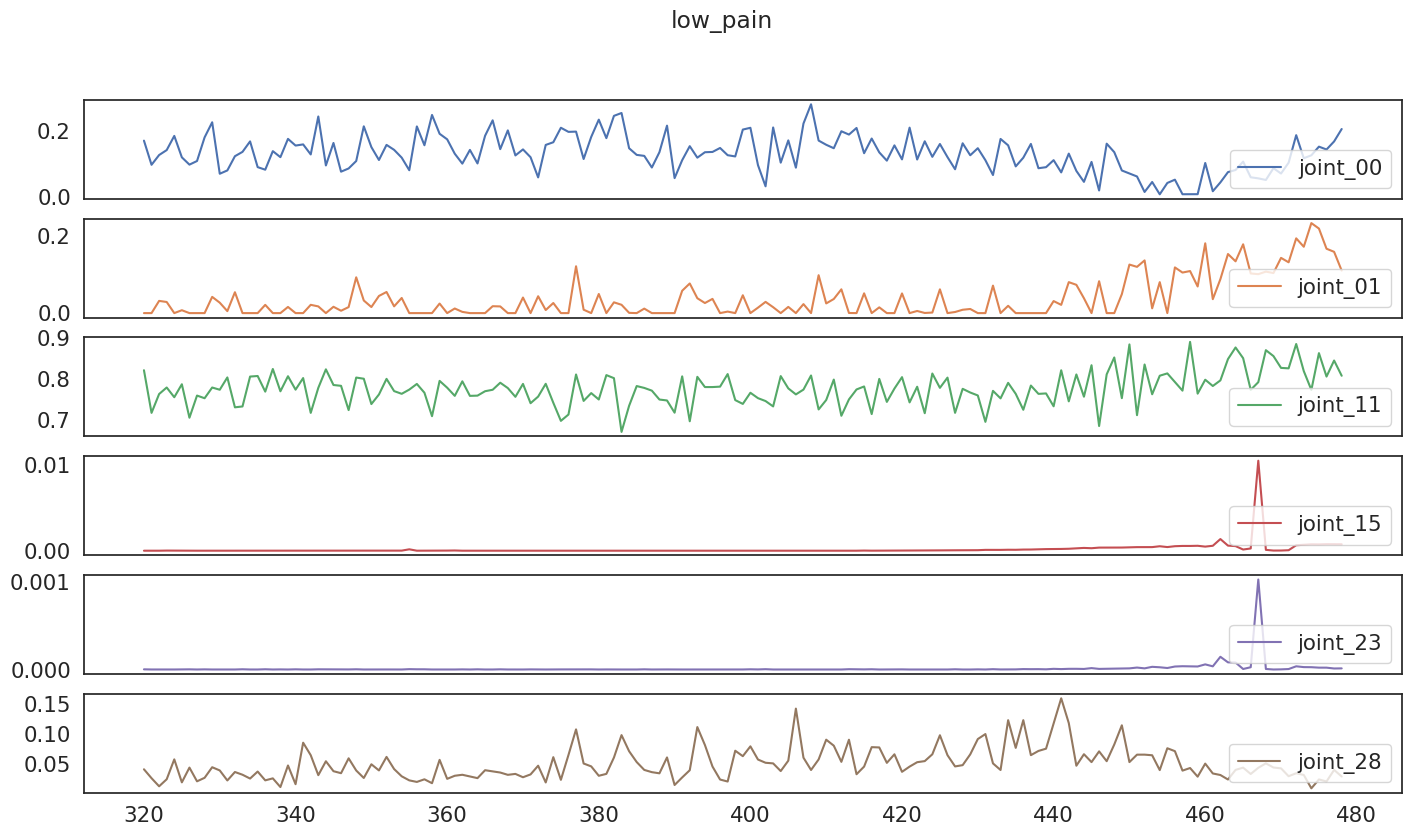

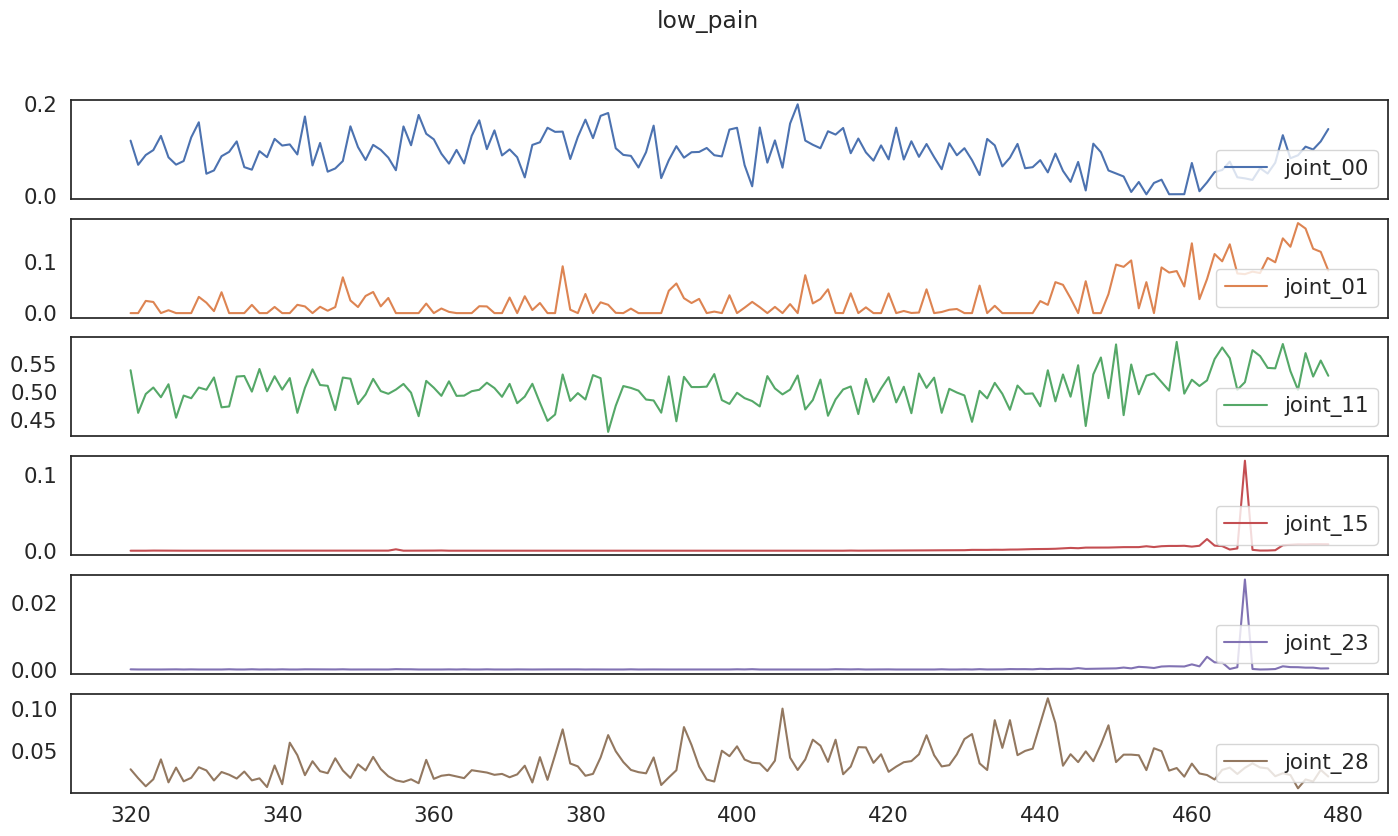

In [15]:
inspect_label('low_pain', data)

# Normalized training data
inspect_label('low_pain', df_train)

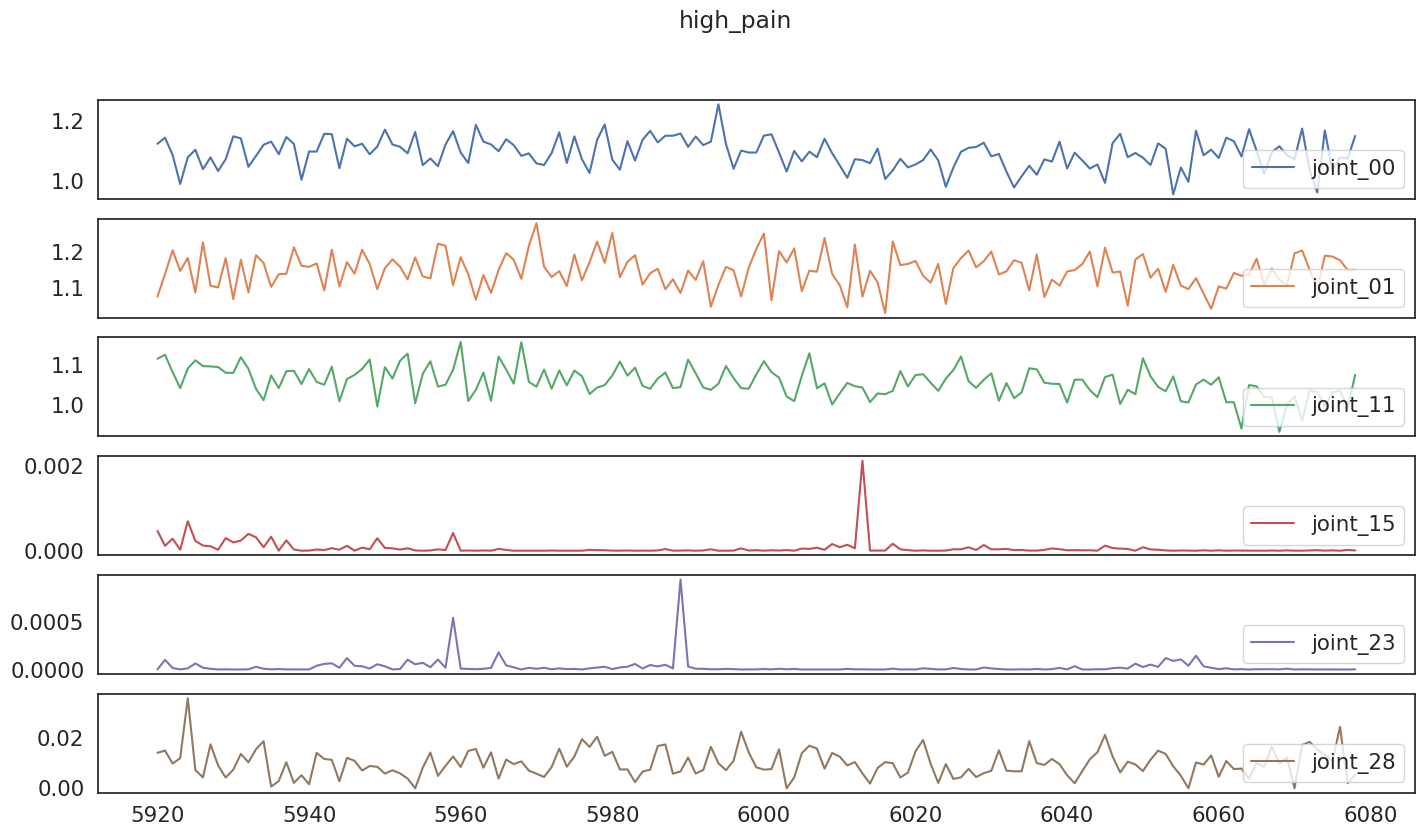

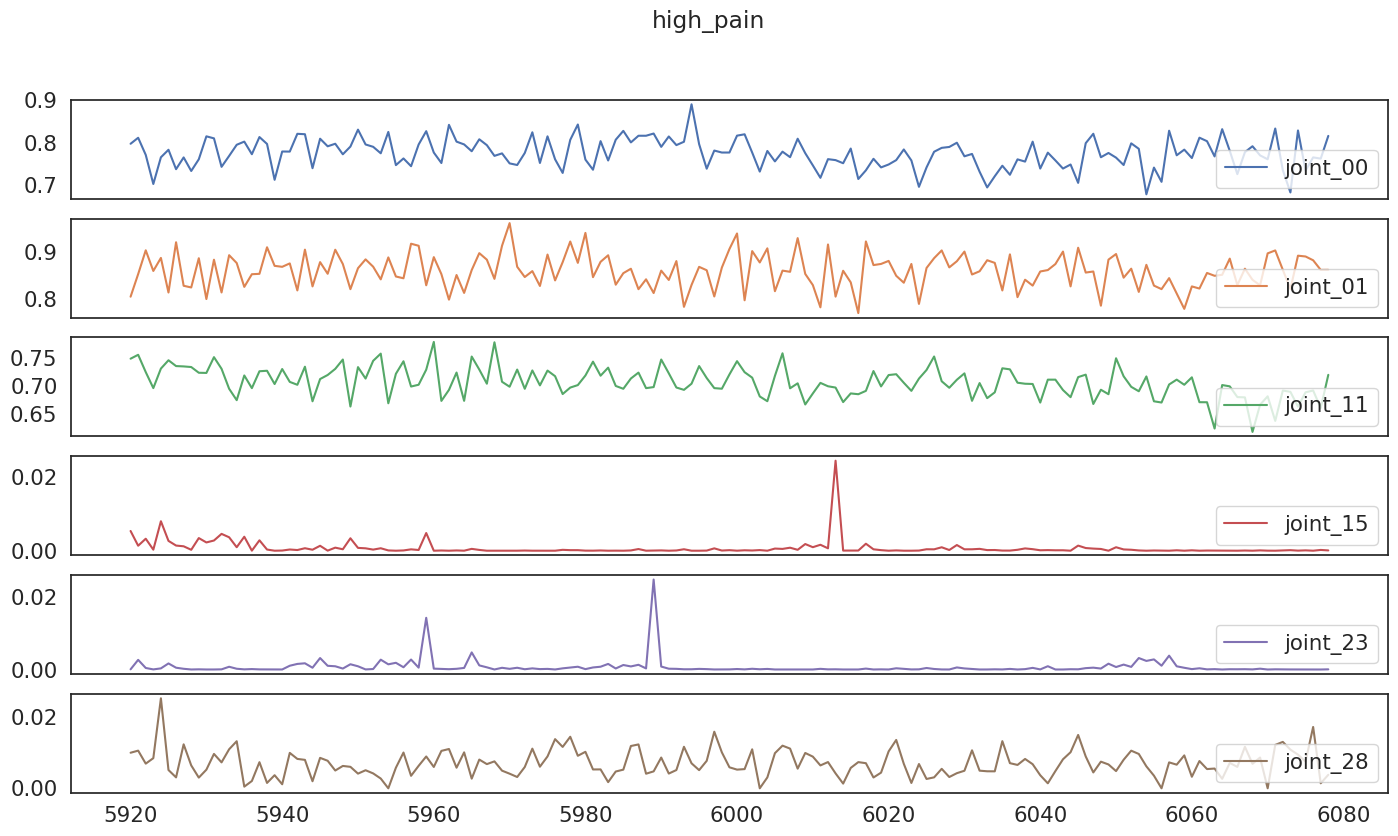

In [16]:
inspect_label('high_pain', data)

# Normalized training data
inspect_label('high_pain', df_train)

In [17]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['sample_index'].unique():
    label = df_train[df_train['sample_index'] == id]['label'].values[0]
    training_labels[label] += 1


if 'joint_30' in df_train.columns:
    df_train = df_train.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of training labels
print('Training labels:', training_labels)

# Initialise a dictionary to count occurrences of each activity in the training set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_val['sample_index'].unique():
    label = df_val[df_val['sample_index'] == id]['label'].values[0]
    val_labels[label] += 1


if 'joint_30' in df_val.columns:
    df_val = df_val.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of validation labels
print('Validation labels:', val_labels)

# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0          
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['sample_index'].unique():
    label = df_test[df_test['sample_index'] == id]['label'].values[0]
    test_labels[label] += 1
if 'joint_30' in df_test.columns:
    df_test = df_test.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of test labels
print('Test labels:', test_labels)

Training labels: {'no_pain': 434, 'low_pain': 80, 'high_pain': 47}
Validation labels: {'no_pain': 39, 'low_pain': 7, 'high_pain': 4}
Test labels: {'no_pain': 38, 'low_pain': 7, 'high_pain': 5}


In [18]:
df_train.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
0,0,0,1.0,0.0,1.0,0.5,2.0,2.0,2.0,0.777046,...,2.426544e-06,1.503263e-06,0.000105,0.000405,0.000004,0.014214,0.011376,0.018978,0.020291,no_pain
1,0,1,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.805855,...,2.757563e-07,4.403064e-07,0.000158,0.000001,0.000000,0.010748,0.000000,0.009473,0.010006,no_pain
2,0,2,1.0,0.0,1.0,1.0,2.0,2.0,2.0,0.767110,...,1.063529e-07,1.575589e-08,0.000038,0.000085,0.000003,0.013097,0.006830,0.017065,0.016856,no_pain
3,0,3,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.665528,...,6.981461e-06,3.352260e-07,0.000049,0.000002,0.000000,0.009505,0.006274,0.020264,0.017981,no_pain
4,0,4,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.773829,...,3.076737e-06,1.885071e-08,0.000041,0.000002,0.000007,0.004216,0.002132,0.023389,0.018477,no_pain


In [19]:
# Define a training mapping of label names to integer labels
train_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the training set
df_train['label'] = df_train['label'].map(train_label_mapping)

# Define a validation mapping of label names to integer labels
val_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the validation set
df_val['label'] = df_val['label'].map(val_label_mapping)

test_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the test set
df_test['label'] = df_test['label'].map(test_label_mapping)


In [35]:
df_train['label'].head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [36]:
df_val['label'].head()

160    0
161    0
162    0
163    0
164    0
Name: label, dtype: int64

In [37]:
df_test['label'].head()

2240    0
2241    0
2242    0
2243    0
2244    0
Name: label, dtype: int64

In [ ]:

# Define window and stride boolean variable -> if True, during training we will visit more time the same pirate with overlapping windows
# if False, each pirate will be visited only once during training
one_pirate_window = False

In [24]:
if one_pirate_window:
    # Define the window size
    WINDOW_SIZE = 80

    # Stride size
    STRIDE = 20
else:
    # Define the window size -> select an higher window size in order to get more pirates
    WINDOW_SIZE = 320

    # Stride size
    STRIDE = 80

In [ ]:
"""
  GENERAL COMMENTS:
  in this function we are restricting for each user data the number of samples of recorded data to a constant
  value (window size), since every user data could be composed by different numbers of timestep. Therefore we are
  "normalizing" the timesteps of a constant window size. Additionally is also defined a stride variable, which if is equal to
  the window size, then we are not taking overlapping timestamp samples, instead if stride < window, we are letting some samples
  to overlap in such a way that the RNN or other kind of NN architecture will analyze better the context.
"""

# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0 # checks if the window size is divisible by the stride

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        
        # Extract pirate sample index data for the current sample index
        columns = [col for col in df.columns if col not in ['sample_index', 'label', 'time']]

        temp = df[df['sample_index'] == id][columns].values

        # Retrieve the label for the current pirate
        label = df[df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [26]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((561, 320, 37), (561,), (50, 320, 37), (50,), (50, 320, 37), (50,))

In [27]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [ ]:

# Discard nan values from the dataset
if np.isnan(X_train).any() or np.isnan(X_val).any() or np.isnan(X_test).any():
    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)
    X_test = np.nan_to_num(X_test)


In [29]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [40]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 256 # we can change it depending on the GPU RAM available (by default 512)

In [41]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [42]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [43]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([256, 320, 37])
Labels batch shape: torch.Size([256])


In [44]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [49]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0 # dropout between RNN layers, applied for regularization

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional, # We are defining a bidirectional RNN since we want to extract also the future contextual information for making better predictions
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes) # output layer for classifying

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x) # feeds the input sequence into the RNN layer
        # rnn_out -> contains the hidden state output for every timestep

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # final hidden state of the last timestep

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='LSTM'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 320, 128], [2, -1, 128]] 217,600        
classifier (Linear)       [-1, 3]                      387            
Total params: 217,987
Trainable params: 217,987
Non-trainable params: 0
-------------------------------------------------------------------------------


## Network Hyperparameters

In [48]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [50]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [51]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy